<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/classificationModelling_RDKiTFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rdkit Feature Based Classification Modelling

## Introduction

Rdkit Features: RDKiT descriptor are easy to calculate descriptors open-sourced under rdkit.Chem.Descriptor modules by RDKit (Rdkit.Chem.Descriptors Module, 2024). Check out documentation here:  [Rdkit Descriptor Module](https://rdkit.org/docs/source/rdkit.Chem.Descriptors.html)

## Data loading and Preprocessing



In [ ]:
# For Reproducibility
import numpy as np
np.random.seed(42)


In [ ]:
# Tpot requires numpy==1.23.3 as of june 2024
!pip install numpy==1.23.3


In [ ]:
# Mount Drive in Colab environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading

Acquisition of the primary molecular dataset of the human acetylcholinesterase inhibitor was done from ChEMBL(ID:ChEMBL22). From 18,204 inhibitor entries, 4077 compounds with reported IC50 value and validated SMILE annotations were chosen, with redundant chemical structures resolved by randomly selecting one from the most frequently occurring activity label group. The resulting dataset comprises 2,330 instances labeled as positive and 1,747 instances labeled as negative. Molecules with an IC50 value less than 1uM were labeled as positives, and greater than 1 uM were labeled as negatives.  

In [ ]:
# Load dataset
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/Part_2_standarizationOfMolecule/StandarizedSmiles_cutOFF800daltonMolecularweight.xlsx')
df.head(5)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [ ]:
# Installing RDKit from PyPI
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 36.0 MB/s eta 0:00:00


### Descriptor generation and feature preparation
Two feature sets were created: one underwent LASSO treatment, which was employed in classical, ensemble, and deep learning models. The other set, devoid of LASSO treatment, was utilized in the AutoML method, as it incorporates its own feature processing and selection methodology within its pipeline.





The code for descriptor calculation was adopted form blogpost by [@greglandrum](https://https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html)

In [ ]:
# Importing pandas as pd
import pandas as pd

# Importing required modules from RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors

# Define a function to calculate the full list of descriptors for a molecule
def calculate_molecular_descriptors(molecule, missing_value=None):
    # Initialize an empty dictionary to store descriptor values
    result = {}

    # Iterate through the descriptor list and calculate descriptors for the molecule
    for name, function in Descriptors._descList:
        # Some descriptor functions may throw errors if they fail, catch those here
        try:
            # Calculate descriptor value for the molecule
            value = function(molecule)
        except:
            # Print the error message
            import traceback
            traceback.print_exc()
            # Set the descriptor value to the specified missing value
            value = missing_value
        # Store the descriptor value in the result dictionary
        result[name] = value
    return result

# Define a list to store the computed descriptors for each molecule
descriptor_list = []

# Iterate through the SMILES column and calculate descriptors for each molecule
for smiles_string in df['cleanedMol']:
    # Convert SMILES string to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles_string)

    # Check if the molecule is valid
    if molecule is not None:
        # Calculate descriptors using the calculate_molecular_descriptors function
        descriptors = calculate_molecular_descriptors(molecule, missing_value=None)

        # Add the descriptors to the list
        descriptor_list.append(descriptors)
    else:
        # Handle invalid or missing molecules if needed
        descriptor_list.append({})

# Convert the list of descriptors to a pandas DataFrame
descriptor_df = pd.DataFrame(descriptor_list)

# Merge the original DataFrame with the descriptor DataFrame
df = pd.concat([df, descriptor_df], axis=1)

In [ ]:
# Drop any feature containing null values
df.dropna(axis=1)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,0,0,0,0,0,0,0,0,0,0
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,0,0,0,0,0,0,0,0,0,0
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,0,0,0,0,0,0,0,0,0,0
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Feature Set for tpot modelling
feature1=df.iloc[:, 15:]

In [ ]:
feature1

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.353370,-0.429125,11.353370,0.098109,0.848240,275.352,254.184,275.163377,108,0,...,0,0,0,0,0,0,0,0,0,0
1,12.152013,-0.507704,12.152013,0.093140,0.906446,325.364,306.212,325.131408,124,0,...,0,0,0,0,0,0,0,0,0,0
2,11.430389,-0.439927,11.430389,0.056694,0.888271,263.293,246.157,263.115758,102,0,...,0,0,0,0,0,0,0,0,0,0
3,6.249844,0.958056,6.249844,0.958056,0.728716,212.296,196.168,212.131349,82,0,...,0,0,0,0,0,0,0,0,0,0
4,11.077636,-0.345833,11.077636,0.112292,0.396155,341.455,314.239,341.210327,134,0,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,13.153269,-1.144692,13.153269,0.039314,0.390527,449.463,426.279,449.158685,170,0,...,0,0,0,0,0,0,0,0,0,0
4073,13.179451,-4.369559,13.179451,0.172737,0.762966,306.307,291.187,306.110025,114,0,...,0,0,0,0,0,0,0,0,0,0
4074,5.424113,0.901816,5.424113,0.901816,0.635009,250.321,234.193,250.122641,94,0,...,0,0,0,0,0,0,0,0,0,0
4075,5.421510,0.854370,5.421510,0.854370,0.679519,266.320,250.192,266.117555,100,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Get the list of columns containing NaN values
columns_with_nan = feature1.columns[feature1.isna().any()].tolist()
print(columns_with_nan)

['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']


In [ ]:

# Calculate variance for each column in 'feature1'.
variances = feature1.var()
# Threshold for low variability.
threshold = 0
# Identify columns with variability below the threshold.
low_variability_columns = variances[variances == threshold].index
# Drop columns with low variability from the DataFrame 'feature1'.
feature1.drop(columns=low_variability_columns, inplace=True)
feature1

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.353370,-0.429125,11.353370,0.098109,0.848240,275.352,254.184,275.163377,108,0.411839,...,0,0,0,0,0,0,0,0,0,0
1,12.152013,-0.507704,12.152013,0.093140,0.906446,325.364,306.212,325.131408,124,0.416597,...,0,0,0,0,0,0,0,0,0,0
2,11.430389,-0.439927,11.430389,0.056694,0.888271,263.293,246.157,263.115758,102,0.412091,...,0,0,0,0,0,0,0,0,0,0
3,6.249844,0.958056,6.249844,0.958056,0.728716,212.296,196.168,212.131349,82,0.072836,...,0,0,0,0,0,0,0,0,0,0
4,11.077636,-0.345833,11.077636,0.112292,0.396155,341.455,314.239,341.210327,134,0.271131,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,13.153269,-1.144692,13.153269,0.039314,0.390527,449.463,426.279,449.158685,170,0.308243,...,0,0,0,0,0,0,0,0,0,0
4073,13.179451,-4.369559,13.179451,0.172737,0.762966,306.307,291.187,306.110025,114,0.422266,...,0,0,0,0,0,0,0,0,0,0
4074,5.424113,0.901816,5.424113,0.901816,0.635009,250.321,234.193,250.122641,94,0.210146,...,0,0,0,0,0,0,0,0,0,0
4075,5.421510,0.854370,5.421510,0.854370,0.679519,266.320,250.192,266.117555,100,0.210400,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target=df['classLabel']
target.head()

0    1
1    1
2    0
3    1
4    1
Name: classLabel, dtype: int64

In [ ]:
# List of column names to drop from the DataFrame 'feature1'.
column_name_to_drop = [
    'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
    'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'
]
# Remove columns with missing value
feature1 = feature1.drop(columns=column_name_to_drop)

### Feature Selection

LASSO (least absolute shrinkage and selection operator) method operated within the framework of ridge regression and subset selection, LASSO efficiently chooses a single feature from highly correlated groups(Muthukrishnan & Rohini, 2016).Features selection  was done through Lasso regression with five fold cross validation alpha selection, and based upon non-zero coefficients.

In [ ]:
feature1.columns.tolist()

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'TPSA',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 

In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(feature1)
# Lasso model with cross-validated alpha selection
lasso_model = LassoCV(cv=5)
# Fit the Lasso model to the standardized feature matrix (X) and the target variable ('classLabel')
lasso_model.fit(X, df['classLabel'])
# Get the selected features based on the coefficients obtained from Lasso regularization
selected_features = feature1.columns[lasso_model.coef_ != 0]
# Create a new feature dataframe containing only the selected features
feature_dataframe = feature1[selected_features]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08395803604673802, tolerance: 0.07976602269242591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21921629724863578, tolerance: 0.07976602269242591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33241649184083144, tolerance: 0.07976602269242591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: Co

## AutoML Modeling

AutoML (specifically TPOT) is an automated optimization method based on trees for enhancing feature processing and machine learning models, with the goal of maximizing classification accuracy through genetic algorithms. It serves as an interface for scikit-learn, wherein each operator in the learning pipeline aligns with a machine learning algorithm or standard feature scaler. Its key components include supervised classification operators, feature processing operators, feature selection operators, and an operator for consolidating modified dataset variants into one (Olson & Moore, 2019). Construction of learning pipelines includes incorporation of operators as genetic programming primitives for creation of genetic programming trees, and a genetic algorithm, implemented in the DEAP python package,  automatically generates and optimizes tree-based pipelines(Fortin, n.d.; Olson et al., 2016; Olson & Moore, 2019)

In [ ]:
!pip install tpot

In [ ]:
# Import necessary libraries
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib


# Split the data into training and test sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(feature1, target, test_size=0.20, stratify=target, random_state=42)
# Create an instance of TPOTClassifier with five fold cross validation
tpot = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=42, verbosity=2)
# Fit TPOT to the training data
tpot.fit(X_train, y_train)
# Get the best pipeline from TPOT
best_pipeline = tpot.fitted_pipeline_


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8638445494602541

Generation 2 - Current best internal CV score: 0.8650729525831696

Generation 3 - Current best internal CV score: 0.8650729525831696

Generation 4 - Current best internal CV score: 0.8650729525831696

Generation 5 - Current best internal CV score: 0.8650729525831696

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=15, n_estimators=100)


### Evaluation of AutoML Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, cohen_kappa_score,
                             matthews_corrcoef, accuracy_score)
from sklearn.model_selection import cross_val_score
import joblib

feature_names = X_train.columns.tolist()
# Make predictions on the test data
y_test_pred = best_pipeline.predict(X_test)

# Calculate evaluation metrics
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_test_pred)
cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Calculate cross-validation scores, std, and 95% CI
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5)
cv_mean_score = np.mean(cv_scores)
cv_std = np.std(cv_scores)
cv_ci = 1.96 * cv_std  # 95% confidence interval

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Store the evaluation results
evaluation_results = {
    'Model': ['TPOT Best Pipeline'],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC-AUC': [roc_auc],
    'Cohen\'s Kappa': [cohen_kappa],
    'MCC': [mcc],
    'CV Mean Score': [cv_mean_score],
    'CV Std Dev': [cv_std],
    'CV 95% CI': [cv_ci],
    'Test Accuracy': [test_accuracy],
    'Features': [feature_names]
}

# Convert the evaluation results to a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Save the evaluation results to an Excel file
evaluation_df.to_excel('tpot_best_pipeline_evaluation.xlsx', index=False)
print("Evaluation results of TPOT best pipeline saved to 'tpot_best_pipeline_evaluation.xlsx'.")

# Display the evaluation results
print("\nEvaluation Results:")
print(evaluation_df)

# Save the best model parameters to a DataFrame
best_model_parameters = pd.DataFrame([best_pipeline.get_params()])

# Combine the evaluation results, best model parameters, and feature names into a single DataFrame
results_df = pd.concat([evaluation_df, best_model_parameters], axis=1)

# Save the combined information to an Excel file
results_df.to_excel('tpot_best_pipeline_results.xlsx', index=False)
print("\nEvaluation results, best model parameters, and feature names saved to 'tpot_best_pipeline_results.xlsx'.")

# Display the combined information
print("\nCombined Information:")
print(results_df)


Evaluation results of TPOT best pipeline saved to 'tpot_best_pipeline_evaluation.xlsx'.

Evaluation Results:
                Model  Precision    Recall  F1 Score  ROC-AUC  Cohen's Kappa  \
0  TPOT Best Pipeline    0.85684  0.856618   0.85576  0.84886       0.704483   

        MCC  CV Mean Score  CV Std Dev  CV 95% CI  Test Accuracy  \
0  0.706127       0.865073    0.009341   0.018309       0.856618   

                                            Features  
0  [MaxEStateIndex, MinEStateIndex, MaxAbsEStateI...  

Evaluation results, best model parameters, and feature names saved to 'tpot_best_pipeline_results.xlsx'.

Combined Information:
                Model  Precision    Recall  F1 Score  ROC-AUC  Cohen's Kappa  \
0  TPOT Best Pipeline    0.85684  0.856618   0.85576  0.84886       0.704483   

        MCC  CV Mean Score  CV Std Dev  CV 95% CI  ...  \
0  0.706127       0.865073    0.009341   0.018309  ...   

   extratreesclassifier__min_samples_leaf  \
0                              

## Aggregrate modelling with hyperparameter optimization and evaluation

The aggregate method involves systematically exploring a diverse array of classical and ensemble machine learning algorithms, coupled with consistent and rigorous hyperparameter optimization, employing five-fold cross-validation, and primarily assessing performance based on the AUC ROC  score. All models are built from sklearn libraries(Supervised Learning, 2024).  Classical model that were used were Decision Tree, Support vector machine, Logistic regression, Mult-layer perceptron, Gradient Boosting, and K-Nearest Neighbors, and ensemble models include random forest, Gradient Boosting, Bagging, AdaBoost, Extra Trees, HistGradientBoosting and Stacking classifier. The ensemble technique merges predictions from multiple models to generate a consensus prediction, with the assumption that errors of one model will be compensated by other models and vice versa(Sagi & Rokach, 2018).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    matthews_corrcoef,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    StackingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import joblib

# Store feature names
feature_names = feature_dataframe.columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_dataframe, target, test_size=0.2, random_state=42)

# Use StandardScaler to scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a dictionary of models to loop through
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Stacking': StackingClassifier(estimators=[('rf', RandomForestClassifier()), ('gb', GradientBoostingClassifier())], final_estimator=LogisticRegression()),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100),
    'HistGradientBoosting': HistGradientBoostingClassifier(max_iter=100)
}

# Define hyperparameters for Grid Search
param_grid = {
    'Random Forest': {'n_estimators': [100, 200, 300]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50, 50)]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'Naive Bayes': {},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1.0]},
    'Bagging': {},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Stacking': {},
    'Extra Trees': {'n_estimators': [100, 200, 300]},
    'HistGradientBoosting': {'max_iter': [100, 200, 300]}
}

# Initialize variables to track the best model and its evaluation metrics
best_models_results = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC-AUC': [],
    'Cohen\'s Kappa': [],
    'MCC': [],
    'Best Parameters': [],
    'CV Mean Score': [],
    'CV Std Dev': [],
    'CV 95% CI': [],
    'Features': []
}

# Initialize variables for the best single model
best_single_model = None
best_single_model_name = None
best_single_model_roc_auc = 0.0
best_single_model_precision = 0.0
best_single_model_recall = 0.0
best_single_model_f1_score = 0.0
best_single_model_cohen_kappa = 0.0
best_single_model_mcc = 0.0
best_single_model_parameters = None
best_single_model_cv_mean_score = 0.0
best_single_model_cv_std_dev = 0.0
best_single_model_cv_ci = 0.0
best_single_model_features = None

# Loop through each model, perform Grid Search, calculate metrics, and create visualizations
for model_name, model in models.items():
    if model_name in param_grid:
        # Perform Grid Search for hyperparameter optimization
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train_scaled, y_train)
        current_best_model = grid_search.best_estimator_
        current_best_hyperparameters = grid_search.best_params_
    else:
        current_best_model = model

    # Calculate cross-validation score
    cv_scores = cross_val_score(current_best_model, X_train_scaled, y_train, cv=5)
    cv_mean_score = cv_scores.mean()
    cv_std_dev = cv_scores.std()
    cv_ci = 1.96 * cv_std_dev  # 95% confidence interval

    # Train the current best model on the full training data
    current_best_model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_test_pred = current_best_model.predict(X_test_scaled)

    # Calculate evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Store the results of the best model for each classifier
    best_models_results['Model'].append(model_name)
    best_models_results['Precision'].append(precision)
    best_models_results['Recall'].append(recall)
    best_models_results['F1 Score'].append(f1)
    best_models_results['ROC-AUC'].append(roc_auc)
    best_models_results['Cohen\'s Kappa'].append(cohen_kappa)
    best_models_results['MCC'].append(mcc)
    best_models_results['Best Parameters'].append(current_best_hyperparameters)
    best_models_results['CV Mean Score'].append(cv_mean_score)
    best_models_results['CV Std Dev'].append(cv_std_dev)
    best_models_results['CV 95% CI'].append(cv_ci)
    best_models_results['Features'].append(feature_names)

    # Update the best single model if the current model has a higher ROC-AUC score
    if roc_auc > best_single_model_roc_auc:
        best_single_model_roc_auc = roc_auc
        best_single_model_name = model_name
        best_single_model_precision = precision
        best_single_model_recall = recall
        best_single_model_f1_score = f1
        best_single_model_cohen_kappa = cohen_kappa
        best_single_model_mcc = mcc
        best_single_model_parameters = current_best_hyperparameters
        best_single_model_cv_mean_score = cv_mean_score
        best_single_model_cv_std_dev = cv_std_dev
        best_single_model_cv_ci = cv_ci
        best_single_model_features = feature_names
        best_single_model = current_best_model

# Convert the dictionary to a DataFrame
best_models_df = pd.DataFrame(best_models_results)

# Save the DataFrame to an Excel file
best_models_df.to_excel('best_models_results.xlsx', index=False)
print("Best models results saved to 'best_models_results.xlsx'.")

# Print the results
print("\nBest Models Results:")
print(best_models_df)

# Save the results of the best single model to a separate Excel file
best_single_model_results = {
    'Model': [best_single_model_name],
    'Precision': [best_single_model_precision],
    'Recall': [best_single_model_recall],
    'F1 Score': [best_single_model_f1_score],
    'ROC-AUC': [best_single_model_roc_auc],
    'Cohen\'s Kappa': [best_single_model_cohen_kappa],
    'MCC': [best_single_model_mcc],
    'Best Parameters': [best_single_model_parameters],
    'CV Mean Score': [best_single_model_cv_mean_score],
    'CV Std Dev': [best_single_model_cv_std_dev],
    'CV 95% CI': [best_single_model_cv_ci],
    'Features': [best_single_model_features]
}

best_single_model_df = pd.DataFrame(best_single_model_results)
best_single_model_df.to_excel('best_single_model_results.xlsx', index=False)
print("\nBest single model results saved to 'best_single_model_results.xlsx'.")

# Print the results of the best single model
print("\nBest Single Model Results:")
print(best_single_model_df)

# Save the trained model of the best single model to a file
joblib.dump(best_single_model, 'best_single_model.pkl')
print("\nTrained model of the best single model saved to 'best_single_model.pkl'.")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best models results saved to 'best_models_results.xlsx'.

Best Models Results:
                   Model  Precision    Recall  F1 Score   ROC-AUC  \
0          Random Forest   0.862531  0.862745  0.862591  0.858847   
1    Logistic Regression   0.777126  0.776961  0.777039  0.772716   
2                    SVM   0.862726  0.860294  0.860763  0.861680   
3                    MLP   0.828814  0.827206  0.827649  0.826665   
4    K-Nearest Neighbors   0.833158  0.830882  0.831415  0.831306   
5          Decision Tree   0.785445  0.783088  0.783747  0.782348   
6            Naive Bayes   0.706622  0.506127  0.419947  0.564396   
7      Gradient Boosting   0.854479  0.854167  0.854291  0.852048   
8                Bagging   0.830451  0.830882  0.830253  0.824194   
9               AdaBoost   0.820584  0.819853  0.820118  0.817738   
10              Stacking   0.864416  0.863971  0.864129  0.862410   
11           Extra Trees   0.868339  0.867647  0.867861  0.866695   
12  HistGradientBoosting

## Cross species evaluation

### Loading species datasets
Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.

In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndepdendent_cleadedIC50.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mosquito.xlsx')

### Descriptor generation for species dataset

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to calculate molecular descriptors for a given molecule
def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm, fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

# Function to calculate descriptors for a dataset
def calculate_descriptors(df, smiles_column):
    descriptor_list = []
    for smiles in df[smiles_column]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol, missingVal=None)
            descriptor_list.append(descriptors)
        else:
            descriptor_list.append({})
    return pd.DataFrame(descriptor_list)

# Calculate descriptors for each dataset
df_humanIndependent_features = calculate_descriptors(df_humanIndependent, 'cleanedMol')
df_eel_features = calculate_descriptors(df_eel, 'cleanedMol')
df_mouse_features = calculate_descriptors(df_mouse, 'cleanedMol')
df_cow_features = calculate_descriptors(df_cow, 'cleanedMol')
df_ray_features = calculate_descriptors(df_ray, 'cleanedMol')
df_mosquito_features = calculate_descriptors(df_mosquito, 'cleanedMol')

# Concatenate original datasets with their respective features
df_humanIndependent = pd.concat([df_humanIndependent, df_humanIndependent_features], axis=1)
df_eel = pd.concat([df_eel, df_eel_features], axis=1)
df_mouse = pd.concat([df_mouse, df_mouse_features], axis=1)
df_cow = pd.concat([df_cow, df_cow_features], axis=1)
df_ray = pd.concat([df_ray, df_ray_features], axis=1)
df_mosquito = pd.concat([df_mosquito, df_mosquito_features], axis=1)


In [ ]:
# drop null or nan smiles
df_humanIndependent=df_humanIndependent.dropna(subset=['Smiles'])
df_eel=df_eel.dropna(subset=['SMILES'])
df_mouse=df_mouse.dropna(subset=['SMILES'])
df_cow=df_cow.dropna(subset=['SMILES'])
df_ray=df_ray.dropna(subset=['SMILES'])
df_mosquito=df_mosquito.dropna(subset=['SMILES'])

In [ ]:
# Get features names compatible with tpot and aggregrate model
tpot_column= feature1.columns.tolist()
optimized_column= feature_dataframe.columns.tolist()

### Dataset Prepartion to be evaluated on tpot model

In [ ]:
# Selecting features compatible with tpot model
df_humanIndependent_features_tpot=df_humanIndependent_features[tpot_column]
df_eel_features_tpot=df_eel_features[tpot_column]
df_mouse_features_tpot=df_mouse_features[tpot_column]
df_cow_features_tpot=df_cow_features[tpot_column]
df_ray_features_tpot=df_ray_features[tpot_column]
df_mosquito_features_tpot=df_mosquito_features[tpot_column]

In [ ]:
# concatening resultant features with the dataset
df_eel_tpot_final=pd.merge(df_eel[['cleanedMol', 'single-class-label']], df_eel_features_tpot, left_index=True, right_index=True)
df_humanIndependent_tpot_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_tpot, left_index=True, right_index=True)
df_mouse_tpot_final=pd.merge(df_mouse[['cleanedMol', 'single-class-label']], df_mouse_features_tpot, left_index=True, right_index=True)
df_cow_tpot_final=pd.merge(df_cow[['cleanedMol', 'single-class-label']], df_cow_features_tpot, left_index=True, right_index=True)
df_ray_tpot_final=pd.merge(df_ray[['cleanedMol', 'single-class-label']], df_ray_features_tpot, left_index=True, right_index=True)
df_mosquito_tpot_final=pd.merge(df_mosquito[['cleanedMol', 'single-class-label']], df_mosquito_features_tpot, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_tpot_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_tpot, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_tpot_final.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)


In [ ]:
 df_humanIndependent_tpot_final.loc[:, 'MaxEStateIndex':]

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.678109,0.070315,12.678109,0.070315,0.517626,400.950,371.718,400.191756,150,1.250000,...,0,0,0,0,0,0,0,0,0,0
1,13.231128,-0.223812,13.231128,0.211490,0.185178,582.793,536.425,582.368225,228,0.674419,...,0,0,0,0,0,0,0,0,4,0
2,13.225251,-0.208616,13.225251,0.192933,0.140817,610.847,560.447,610.399525,240,0.644444,...,0,0,0,0,0,0,0,0,6,0
3,13.624280,-0.226583,13.624280,0.211682,0.121615,618.826,572.458,618.368225,240,0.608696,...,0,0,0,0,0,0,0,0,4,0
4,6.295324,1.003148,6.295324,1.003148,0.667469,213.304,196.168,213.138625,82,1.125000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,12.709629,-0.374291,12.709629,0.196689,0.457871,427.504,402.304,427.189592,162,0.937500,...,0,0,0,0,0,0,0,0,0,0
204,12.808047,-0.400249,12.808047,0.163325,0.409022,457.530,430.314,457.200156,174,0.882353,...,0,0,0,0,0,0,0,0,0,0
205,13.246372,-0.243184,13.246372,0.235564,0.238857,554.739,512.403,554.336925,216,0.707317,...,0,0,0,0,0,0,0,0,2,0
206,13.026137,-0.234411,13.026137,0.224564,0.272877,526.685,488.381,526.305624,204,0.692308,...,0,0,0,0,0,0,0,0,8,0


### Test Dataset Prep - tpot




In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature1, target, test_size=0.2, random_state=42)

In [ ]:
X_test

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
1749,5.972043,0.756114,5.972043,0.756114,0.683627,393.922,369.730,393.172023,144,0.857143,...,0,0,0,0,0,0,0,0,0,0
2053,11.822159,-0.422158,11.822159,0.372346,0.348568,438.524,408.284,438.215472,170,1.062500,...,0,0,0,0,0,0,0,0,2,0
538,12.422838,-0.039308,12.422838,0.039308,0.498668,370.476,346.284,370.191389,140,1.035714,...,0,0,0,0,0,0,0,0,0,0
438,4.951494,1.089606,4.951494,1.089606,0.340832,409.662,366.318,409.345698,166,0.800000,...,0,0,0,0,0,0,0,0,10,0
2685,12.787253,-0.019397,12.787253,0.019397,0.503110,426.583,402.391,426.119212,150,1.103448,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,12.250370,0.003338,12.250370,0.003338,0.247795,379.544,346.280,379.251129,150,0.892857,...,0,0,0,0,0,0,0,0,4,0
3937,11.332316,-0.499679,11.332316,0.441842,0.284048,329.360,310.208,329.147692,124,1.166667,...,0,0,0,0,0,0,0,0,0,0
221,13.473408,-0.851792,13.473408,0.234384,0.245487,537.656,502.376,537.251523,206,0.500000,...,0,0,0,0,0,0,0,0,0,0
2031,12.022269,0.038994,12.022269,0.038994,0.878936,322.452,296.244,322.204513,126,0.958333,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df = pd.merge(df[['cleanedMol', 'classLabel']], X_test, left_index=True, right_index=True, how='inner')

In [ ]:
test_df.rename(columns={'classLabel': 'single-class-label'}, inplace=True)


In [ ]:
test_df

,cleanedMol,single-class-label,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
6,Nc1c2c(nc3ccccc13)CCCC2,1,6.199769,0.953981,6.199769,0.953981,0.706488,198.269,184.157,198.115698,...,0,0,0,0,0,0,0,0,0,0
8,O=[N+]([O-])OCCCNCCCCNc1c2c(nc3ccccc13)CCCC2,1,10.046839,-0.742861,10.046839,0.154546,0.356480,372.469,344.245,372.216141,...,0,0,0,0,0,0,0,0,7,0
12,COc1ccc(C(=O)c2ccc(CN(C)Cc3ccccc3)cc2)cc1,0,12.569376,0.024855,12.569376,0.024855,0.588089,345.442,322.258,345.172879,...,0,0,0,0,0,0,0,0,0,0
14,C=CC[N+](C)(C)c1ccc(OC(C)=O)cc1,0,10.758086,-0.298526,10.758086,0.298526,0.336849,220.292,202.148,220.133205,...,1,0,0,0,0,0,0,0,0,0
17,CN(CCCCCCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1ccccc1Cl,0,12.623533,-0.003786,12.623533,0.003786,0.176201,464.005,433.765,463.191421,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,N#Cc1ccc(CN2CCC(Nc3nc(-c4ccc(Cl)cc4)c(-c4ccc(C...,0,8.987949,0.383797,8.987949,0.383797,0.283264,519.501,495.309,518.109873,...,0,0,0,0,0,0,1,0,0,0
4064,CNc1nc(NCCc2ccccc2)c2ccccc2n1,0,4.517236,0.635103,4.517236,0.635103,0.751376,278.359,260.215,278.153147,...,0,0,0,0,0,0,0,0,0,0
4070,CC(C)=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@@]2(CC=C(...,0,15.262323,-1.970036,15.262323,0.001837,0.227299,568.795,516.379,568.376389,...,0,0,0,0,0,0,0,0,0,0
4071,O=C1C(=O)N(C(=O)c2ccccc2)c2ccc(CN3CCCCC3)cc21,1,12.712094,-0.774097,12.712094,0.327584,0.631875,348.402,328.242,348.147393,...,0,0,0,0,0,0,0,0,0,0


### Evaluation of different species dataset on tpot model

Confusion Matrix for Human Test dataset:
[[445  21]
 [ 21 329]]
Confusion Matrix for Human Independent dataset:
[[124  14]
 [ 24  46]]
Confusion Matrix for Eel dataset:
[[2896  479]
 [ 948 1136]]
Confusion Matrix for Mouse dataset:
[[200  23]
 [ 28 117]]
Confusion Matrix for Cow dataset:
[[177  41]
 [ 32 207]]
Confusion Matrix for Ray dataset:
[[518 201]
 [301 386]]
Confusion Matrix for Mosquito dataset:
[[45  0]
 [12 15]]


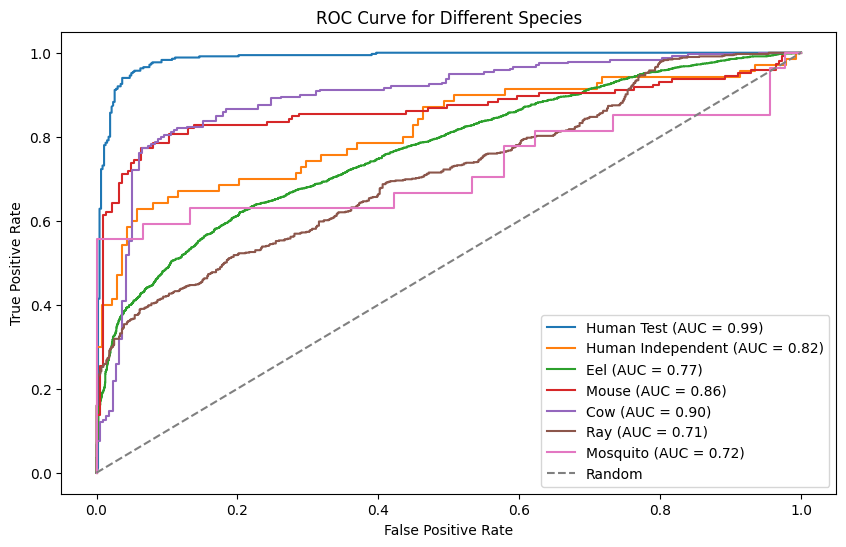

Evaluation for Human Test dataset:
Accuracy: 0.9485
Precision: 0.9400
Recall: 0.9400
F1 Score: 0.9400
MCC: 0.8949
Cohen's Kappa: 0.8949
Predicted Positives: 350.0000
Predicted Negatives: 466.0000


Evaluation for Human Independent dataset:
Accuracy: 0.8173
Precision: 0.7667
Recall: 0.6571
F1 Score: 0.7077
MCC: 0.5796
Cohen's Kappa: 0.5760
Predicted Positives: 60.0000
Predicted Negatives: 148.0000


Evaluation for Eel dataset:
Accuracy: 0.7386
Precision: 0.7034
Recall: 0.5451
F1 Score: 0.6142
MCC: 0.4291
Cohen's Kappa: 0.4213
Predicted Positives: 1615.0000
Predicted Negatives: 3844.0000


Evaluation for Mouse dataset:
Accuracy: 0.8614
Precision: 0.8357
Recall: 0.8069
F1 Score: 0.8211
MCC: 0.7083
Cohen's Kappa: 0.7080
Predicted Positives: 140.0000
Predicted Negatives: 228.0000


Evaluation for Cow dataset:
Accuracy: 0.8403
Precision: 0.8347
Recall: 0.8661
F1 Score: 0.8501
MCC: 0.6798
Cohen's Kappa: 0.6793
Predicted Positives: 248.0000
Predicted Negatives: 209.0000


Evaluation for Ray da

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dictionary of datasets
datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent_tpot_final,
    'Eel': df_eel_tpot_final,
    'Mouse': df_mouse_tpot_final,
    'Cow': df_cow_tpot_final,
    'Ray': df_ray_tpot_final,
    'Mosquito': df_mosquito_tpot_final
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Initialize a dictionary to store predictions and probabilities for each dataset
prediction_data = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():
    X = data.loc[:, 'MaxEStateIndex':]
    y = data['single-class-label']
    # Get predicted probabilities for each class
    y_probs = best_pipeline.predict_proba(X)

    # Extract probabilities for each class
    y_prob_negative = y_probs[:, 0]  # Probability for the negative class
    y_prob_positive = y_probs[:, 1]  # Probability for the positive class

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Evaluate the model
    y_pred = best_pipeline.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cohen_kappa = cohen_kappa_score(y, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Include predicted positives and negatives
    predicted_positives = sum(y_pred == 1)
    predicted_negatives = sum(y_pred == 0)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa,
        'Predicted Positives': predicted_positives,
        'Predicted Negatives': predicted_negatives
    }

    # Store the predictions, true labels, and probabilities in a DataFrame
    df_predictions_species = pd.DataFrame({
        'True_Labels': y,
        'Predictions': y_pred,
        'Probabilities_Negative': y_prob_negative,
        'Probabilities_Positive': y_prob_positive
    })

    # Reset the index to start from 0
    df_predictions_species.reset_index(drop=True, inplace=True)

    # Save the DataFrame to an Excel file
    df_predictions_species.to_excel(f'{species}_tpot_predictions_data.xlsx', index_label='Index')

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(cm)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_tpot.xlsx', index_label='Species')


### Dataset preparation for aggregrate model evaluation

In [ ]:
df_humanIndependent_features_optimized=df_humanIndependent_features[optimized_column]
df_eel_features_optimized=df_eel_features[optimized_column]
df_mouse_features_optimized=df_mouse_features[optimized_column]
df_cow_features_optimized=df_cow_features[optimized_column]
df_ray_features_optimized=df_ray_features[optimized_column]
df_mosquito_features_optimized=df_mosquito_features[optimized_column]

In [ ]:
df_humanIndependent_optimized_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_optimized, left_index=True, right_index=True)

In [ ]:
df_eel_optimized_final=pd.merge(df_eel[['cleanedMol', 'single-class-label']], df_eel_features_optimized, left_index=True, right_index=True)

In [ ]:
df_mouse_optimized_final=pd.merge(df_mouse[['cleanedMol', 'single-class-label']], df_mouse_features_optimized, left_index=True, right_index=True)
df_cow_optimized_final=pd.merge(df_cow[['cleanedMol', 'single-class-label']], df_cow_features_optimized, left_index=True, right_index=True)
df_ray_optimized_final=pd.merge(df_ray[['cleanedMol', 'single-class-label']], df_ray_features_optimized, left_index=True, right_index=True)
df_mosquito_optimized_final=pd.merge(df_mosquito[['cleanedMol', 'single-class-label']], df_mosquito_features_optimized, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_optimized_final.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)


In [ ]:
df_humanIndependent_optimized_final

,cleanedMol,single-class-label,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,12.678109,12.678109,0.070315,0.517626,2.678571,1.488640,8.151633,4.091376,...,0,0,0,0,0,0,0,0,0,0
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1,13.231128,13.231128,0.211490,0.185178,1.604651,1.447012,11.106566,5.481678,...,0,0,0,0,0,0,0,0,4,0
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1,13.225251,13.225251,0.192933,0.140817,1.555556,1.386379,11.813672,5.835232,...,0,0,0,0,0,0,0,0,6,0
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1,13.624280,13.624280,0.211682,0.121615,1.608696,1.315271,11.804911,6.062634,...,0,0,0,0,0,0,0,0,4,0
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0,6.295324,6.295324,1.003148,0.667469,2.750000,2.437782,4.622195,2.851498,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0,12.709629,12.709629,0.196689,0.457871,2.312500,1.426907,7.767714,3.635530,...,0,0,0,0,0,0,0,0,0,0
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0,12.808047,12.808047,0.163325,0.409022,2.147059,1.452138,8.108975,3.853177,...,0,0,0,0,0,0,0,0,0,0
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1,13.246372,13.246372,0.235564,0.238857,1.634146,1.520507,10.399459,5.128125,...,0,0,0,0,0,0,0,0,2,0
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1,13.026137,13.026137,0.224564,0.272877,1.692308,1.361904,9.722581,4.609766,...,0,0,0,0,0,0,0,0,8,0


In [ ]:
df_humanIndependent_optimized_final.loc[:, 'MaxEStateIndex':]

,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,HallKierAlpha,Ipc,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.678109,12.678109,0.070315,0.517626,2.678571,1.488640,8.151633,4.091376,-2.04,1.961110e+06,...,0,0,0,0,0,0,0,0,0,0
1,13.231128,13.231128,0.211490,0.185178,1.604651,1.447012,11.106566,5.481678,-3.98,2.849920e+09,...,0,0,0,0,0,0,0,0,4,0
2,13.225251,13.225251,0.192933,0.140817,1.555556,1.386379,11.813672,5.835232,-3.98,7.543273e+09,...,0,0,0,0,0,0,0,0,6,0
3,13.624280,13.624280,0.211682,0.121615,1.608696,1.315271,11.804911,6.062634,-4.50,1.826452e+10,...,0,0,0,0,0,0,0,0,4,0
4,6.295324,6.295324,1.003148,0.667469,2.750000,2.437782,4.622195,2.851498,-1.57,7.740566e+03,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,12.709629,12.709629,0.196689,0.457871,2.312500,1.426907,7.767714,3.635530,-3.90,1.960623e+07,...,0,0,0,0,0,0,0,0,0,0
204,12.808047,12.808047,0.163325,0.409022,2.147059,1.452138,8.108975,3.853177,-4.10,4.868677e+07,...,0,0,0,0,0,0,0,0,0,0
205,13.246372,13.246372,0.235564,0.238857,1.634146,1.520507,10.399459,5.128125,-3.98,1.076649e+09,...,0,0,0,0,0,0,0,0,2,0
206,13.026137,13.026137,0.224564,0.272877,1.692308,1.361904,9.722581,4.609766,-3.98,4.703120e+08,...,0,0,0,0,0,0,0,0,8,0


In [ ]:
joblib.dump(best_pipeline, 'best_pipeline_tpot.pkl')


['best_pipeline_tpot.pkl']

### Test dataset prep - aggregrate

> Add blockquote



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_dataframe, target, test_size=0.2, random_state=42)

In [ ]:
X_test

,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,HallKierAlpha,Ipc,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
1749,5.972043,5.972043,0.756114,0.683627,2.357143,1.307801,7.407131,3.467691,-2.63,3.895596e+06,...,0,0,0,0,0,0,0,0,0,0
2053,11.822159,11.822159,0.372346,0.348568,2.750000,1.412670,7.711116,3.263666,-3.32,1.427772e+07,...,0,0,0,0,0,0,0,0,2,0
538,12.422838,12.422838,0.039308,0.498668,2.678571,1.330767,7.113602,3.486637,-3.40,4.039194e+06,...,0,0,0,0,0,0,0,0,0,0
438,4.951494,4.951494,1.089606,0.340832,2.166667,1.305270,9.401893,4.755120,-1.61,7.087381e+06,...,0,0,0,0,0,0,0,0,10,0
2685,12.787253,12.787253,0.019397,0.503110,2.551724,1.326984,9.126764,5.475365,-2.31,7.090368e+06,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,12.250370,12.250370,0.003338,0.247795,2.250000,1.654287,6.922203,3.068595,-2.39,2.175464e+06,...,0,0,0,0,0,0,0,0,4,0
3937,11.332316,11.332316,0.441842,0.284048,2.541667,1.874879,5.106724,2.168484,-3.29,2.357526e+05,...,0,0,0,0,0,0,0,0,0,0
221,13.473408,13.473408,0.234384,0.245487,1.375000,1.361104,9.855449,4.769276,-3.81,1.834196e+09,...,0,0,0,0,0,0,0,0,0,0
2031,12.022269,12.022269,0.038994,0.878936,2.250000,1.345540,6.615723,3.356259,-2.13,4.437709e+05,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,0,0,0,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,0,0,0,0,0,0,0,0,0,0
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,0,0,0,0,0,0,0,0,0,0
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,0,0,0,0,0,0,0,0,0,0
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df = pd.merge(df[['cleanedMol', 'classLabel']], X_test, left_index=True, right_index=True, how='inner')

In [ ]:
test_df.rename(columns={'classLabel': 'single-class-label'}, inplace=True)


In [ ]:
test_df

,cleanedMol,single-class-label,MaxEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,FpDensityMorgan3,BalabanJ,Chi2v,Chi4v,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
6,Nc1c2c(nc3ccccc13)CCCC2,1,6.199769,6.199769,0.953981,0.706488,2.800000,2.359120,4.174982,2.409749,...,0,0,0,0,0,0,0,0,0,0
8,O=[N+]([O-])OCCCNCCCCNc1c2c(nc3ccccc13)CCCC2,1,10.046839,10.046839,0.154546,0.356480,2.740741,1.444585,6.930574,3.624129,...,0,0,0,0,0,0,0,0,7,0
12,COc1ccc(C(=O)c2ccc(CN(C)Cc3ccccc3)cc2)cc1,0,12.569376,12.569376,0.024855,0.588089,1.807692,1.626308,6.412438,2.933258,...,0,0,0,0,0,0,0,0,0,0
14,C=CC[N+](C)(C)c1ccc(OC(C)=O)cc1,0,10.758086,10.758086,0.298526,0.336849,2.375000,2.852640,4.243791,1.511853,...,1,0,0,0,0,0,0,0,0,0
17,CN(CCCCCCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1ccccc1Cl,0,12.623533,12.623533,0.003786,0.176201,2.454545,1.156100,8.937933,4.267351,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,N#Cc1ccc(CN2CCC(Nc3nc(-c4ccc(Cl)cc4)c(-c4ccc(C...,0,8.987949,8.987949,0.383797,0.283264,2.085714,1.284405,10.585963,5.657074,...,0,0,0,0,0,0,1,0,0,0
4064,CNc1nc(NCCc2ccccc2)c2ccccc2n1,0,4.517236,4.517236,0.635103,0.751376,2.476190,1.793077,4.825345,2.293074,...,0,0,0,0,0,0,0,0,0,0
4070,CC(C)=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@@]2(CC=C(...,0,15.262323,15.262323,0.001837,0.227299,2.073171,2.483495,14.530497,7.461522,...,0,0,0,0,0,0,0,0,0,0
4071,O=C1C(=O)N(C(=O)c2ccccc2)c2ccc(CN3CCCCC3)cc21,1,12.712094,12.712094,0.327584,0.631875,2.384615,1.624358,6.829174,3.671723,...,0,0,0,0,0,0,0,0,0,0


### Evaluation of species dataset on best model -- aggregrate modeling

Confusion Matrix for Human Test dataset:
[[414  52]
 [ 51 299]]
Confusion Matrix for Human Independent dataset:
[[131   7]
 [ 33  37]]
Confusion Matrix for Eel dataset:
[[2946  429]
 [ 994 1090]]
Confusion Matrix for Mouse dataset:
[[206  17]
 [ 63  82]]
Confusion Matrix for Cow dataset:
[[202  16]
 [ 70 169]]
Confusion Matrix for Ray dataset:
[[573 146]
 [339 348]]
Confusion Matrix for Mosquito dataset:
[[40  5]
 [26  1]]


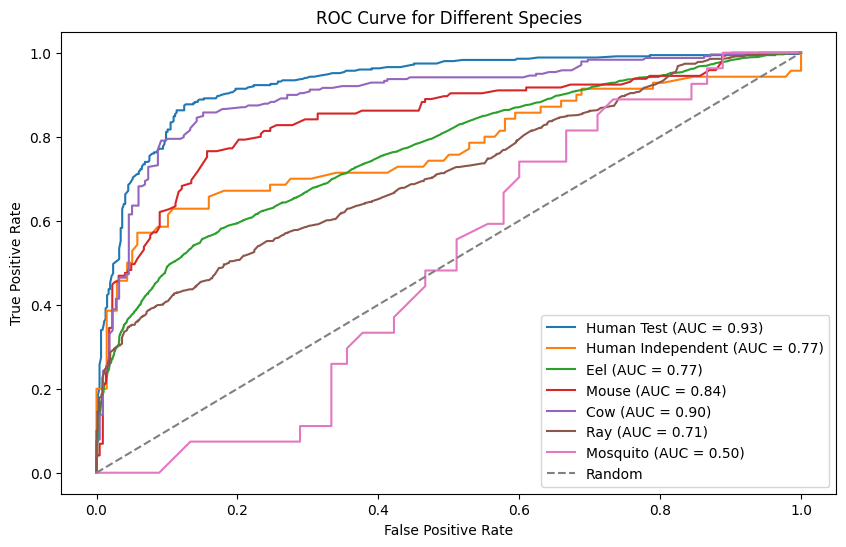

Evaluation for Human Test dataset:
Accuracy: 0.8738
Precision: 0.8519
Recall: 0.8543
F1 Score: 0.8531
MCC: 0.7424
Cohen's Kappa: 0.7424
Predicted Positives: 351.0000
Predicted Negatives: 465.0000


Evaluation for Human Independent dataset:
Accuracy: 0.8077
Precision: 0.8409
Recall: 0.5286
F1 Score: 0.6491
MCC: 0.5529
Cohen's Kappa: 0.5260
Predicted Positives: 44.0000
Predicted Negatives: 164.0000


Evaluation for Eel dataset:
Accuracy: 0.7393
Precision: 0.7176
Recall: 0.5230
F1 Score: 0.6051
MCC: 0.4292
Cohen's Kappa: 0.4176
Predicted Positives: 1519.0000
Predicted Negatives: 3940.0000


Evaluation for Mouse dataset:
Accuracy: 0.7826
Precision: 0.8283
Recall: 0.5655
F1 Score: 0.6721
MCC: 0.5391
Cohen's Kappa: 0.5180
Predicted Positives: 99.0000
Predicted Negatives: 269.0000


Evaluation for Cow dataset:
Accuracy: 0.8118
Precision: 0.9135
Recall: 0.7071
F1 Score: 0.7972
MCC: 0.6448
Cohen's Kappa: 0.6269
Predicted Positives: 185.0000
Predicted Negatives: 272.0000


Evaluation for Ray dat

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dictionary of datasets
datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent_optimized_final,
    'Eel': df_eel_optimized_final,
    'Mouse': df_mouse_optimized_final,
    'Cow': df_cow_optimized_final,
    'Ray': df_ray_optimized_final,
    'Mosquito': df_mosquito_optimized_final
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Initialize a dictionary to store predictions and probabilities for each dataset
prediction_data = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():
    # Assuming your target variable is named 'single-class-label'
    scaler = StandardScaler()
    X = scaler.fit_transform(data.loc[:, 'MaxEStateIndex':])
    y = data['single-class-label']

    # Split the dataset into train and test sets

    # Train a RandomForestClassifier as an example (replace with your best model)
    # best_pipeline.fit(X_train, y_train)

    # Get predicted probabilities for each class
    y_probs = best_single_model.predict_proba(X)

    # Extract probabilities for each class
    y_prob_negative = y_probs[:, 0]  # Probability for the negative class
    y_prob_positive = y_probs[:, 1]  # Probability for the positive class

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Evaluate the model
    y_pred = best_single_model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cohen_kappa = cohen_kappa_score(y, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Include predicted positives and negatives
    predicted_positives = sum(y_pred == 1)
    predicted_negatives = sum(y_pred == 0)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa,
        'Predicted Positives': predicted_positives,
        'Predicted Negatives': predicted_negatives
    }

    # Store the predictions, true labels, and probabilities in a DataFrame
    df_predictions_species = pd.DataFrame({
        'True_Labels': y,
        'Predictions': y_pred,
        'Probabilities_Negative': y_prob_negative,
        'Probabilities_Positive': y_prob_positive
    })

    # Reset the index to start from 0
    df_predictions_species.reset_index(drop=True, inplace=True)

    # Save the DataFrame to an Excel file
    df_predictions_species.to_excel(f'{species}_optimized_predictions_data.xlsx', index_label='Index')

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(cm)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_optimized_specieswide.xlsx', index_label='Species')


## Conclusion
Both advanced modeling approaches showed promising results in predicting acetylcholinesterase activity. AutoML tool TPOT demonstrated superior performance, achieving a ROC AUC of 99% on the test dataset. The best model identified through TPOT modeling was an ExtraTreesClassifier with parameters including bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=15, and n_estimators=100. Additionally, an ExtraTree Classifier with 'n_estimators': 200 emerged as the top model in aggregate modeling. Cross-species evaluation indicated strong performance across all datasets, with the TPOT model excelling particularly in human-specific tests and independent datasets.

## Referenes
*  Muthukrishnan, R., & Rohini, R. (2016). LASSO: A feature selection technique in predictive modeling for machine learning. 2016 IEEE International Conference on Advances in Computer Applications (ICACA), 18–20. https://doi.org/10.1109/ICACA.2016.7887916
*   Rdkit.Chem.Descriptors module. (2024). RDKiT. https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html
* https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
*   Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283






